Start of project


**DOWNLOADS 91 IMAGES DATASET**

In [2]:
import requests 
url_91 = 'https://drive.google.com/uc?export=download&id=1eVfd2Snh5bCl0ulMsRE4ker_p-o1M_lm'
url_set5 = 'https://drive.google.com/uc?export=download&id=1Cr4puJ1UpkXrGpzdpqZLNhZiZ2vaimoi'
url_set14 = 'https://drive.google.com/uc?export=download&id=1PQus6Glc3VsfVIywG6MAMBBBZVyyF_gB'
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

download_url(url_91, './91.zip')
download_url(url_set5, './set5.zip')
download_url(url_set14, './set14.zip')

In [ ]:
!unzip './91.zip' -d './train_data'
!unzip './set5.zip' -d './test_data'
!unzip './set14.zip' -d './test_data'

In [3]:
from zipfile import ZipFile

with ZipFile('91.zip', 'r') as zipObj:
  zipObj.extractall('./train_data')

with ZipFile('set5.zip', 'r') as zipObj:
  zipObj.extractall('./test_data')

with ZipFile('set14.zip', 'r') as zipObj:
  zipObj.extractall('./test_data')

In [0]:
PATH_OF_DATA= '/content/gdrive/"My Drive"/ESPCN/Set5'
!ls {PATH_OF_DATA}

ls: cannot access '/content/gdrive/My Drive/ESPCN/Set5': No such file or directory


In [33]:
from skimage import io, transform
from os import listdir
from os.path import isfile, join
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import PIL

class SuperResolutionDataset(Dataset):

  def __init__(self, root_dir, upscale_factor):
    self.root_dir = root_dir
    self.upscale_factor = upscale_factor
    self.images = [f for f in listdir(self.root_dir) if f.endswith('.bmp')]
    print(self.images)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = io.imread(self.root_dir + '/' + self.images[idx])

    h, w = len(image), len(image[0])
    cropped_h = h - (h % self.upscale_factor)
    cropped_w = w - (w % self.upscale_factor)

    target_transform = transforms.Compose([
         transforms.ToPILImage(),
         transforms.CenterCrop([cropped_h, cropped_w]),
         transforms.ToTensor(),
       ])
    
    input_transform = transforms.Compose([
         transforms.ToPILImage(),
         transforms.CenterCrop([cropped_h, cropped_w]),
         transforms.Resize([int(cropped_h/self.upscale_factor),
                            int(cropped_w/self.upscale_factor)],
                           PIL.Image.BICUBIC),
         transforms.ToTensor(),
       ])
    
    target_image = target_transform(image)
    input_image = input_transform(image)

    return input_image, target_image

  def imshow_input(self, idx):
      img, _ = self.__getitem__(idx)
      img = torchvision.utils.make_grid(img)
      npimg = img.numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
      plt.show()
  
  def imshow_target(self, idx):
      _, img = self.__getitem__(idx)
      img = torchvision.utils.make_grid(img)
      npimg = img.numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
      plt.show()



[In this repo they made a costum loader. ](https://github.com/leftthomas/ESPCN)


In [50]:
import torch
import torchvision
import torchvision.transforms as transforms

import os

bs = 1
r = 4

# Getting image data
transform = transforms.Compose(
    [transforms.ToTensor()])#,

training_set = SuperResolutionDataset('train_data/Set91', r)
# training_set = torchvision.datasets.ImageFolder(root='/content/gdrive/"My Drive"/ESPCN/Set5',
#                                      transform=transform)

train_loader = torch.utils.data.DataLoader(training_set,
                                           batch_size=bs,
                                           shuffle=True,
                                           num_workers=1)
                                           
test_set1 = SuperResolutionDataset('test_data/Set14', r)
test_loader1 = torch.utils.data.DataLoader(training_set,
                                           batch_size=bs,
                                           shuffle=True,
                                           num_workers=0)

test_set2 = SuperResolutionDataset('test_data/Set5', r)
test_loader2 = torch.utils.data.DataLoader(training_set,
                                           batch_size=bs,
                                           shuffle=True,
                                           num_workers=0)


['t1.bmp', 't10.bmp', 't11.bmp', 't12.bmp', 't13.bmp', 't14.bmp', 't15.bmp', 't16.bmp', 't17.bmp', 't18.bmp', 't19.bmp', 't2.bmp', 't20.bmp', 't21.bmp', 't22.bmp', 't23.bmp', 't24.bmp', 't25.bmp', 't26.bmp', 't27.bmp', 't28.bmp', 't29.bmp', 't3.bmp', 't30.bmp', 't31.bmp', 't32.bmp', 't33.bmp', 't34.bmp', 't35.bmp', 't36.bmp', 't37.bmp', 't38.bmp', 't39.bmp', 't4.bmp', 't40.bmp', 't42.bmp', 't43.bmp', 't44.bmp', 't45.bmp', 't46.bmp', 't47.bmp', 't48.bmp', 't49.bmp', 't5.bmp', 't50.bmp', 't51.bmp', 't52.bmp', 't53.bmp', 't54.bmp', 't55.bmp', 't56.bmp', 't57.bmp', 't58.bmp', 't59.bmp', 't6.bmp', 't60.bmp', 't61.bmp', 't62.bmp', 't63.bmp', 't64.bmp', 't65.bmp', 't66.bmp', 't7.bmp', 't8.bmp', 't9.bmp', 'tt1.bmp', 'tt10.bmp', 'tt12.bmp', 'tt13.bmp', 'tt14.bmp', 'tt15.bmp', 'tt16.bmp', 'tt17.bmp', 'tt18.bmp', 'tt19.bmp', 'tt2.bmp', 'tt20.bmp', 'tt21.bmp', 'tt22.bmp', 'tt23.bmp', 'tt24.bmp', 'tt25.bmp', 'tt26.bmp', 'tt27.bmp', 'tt3.bmp', 'tt4.bmp', 'tt5.bmp', 'tt6.bmp', 'tt7.bmp', 'tt8.bmp', '

In [47]:
# Model
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, r, l=3, activation=nn.Identity()):
        super().__init__()
        self.l = l
        self.r = r
        
        self.activation = activation

        self.conv1 = nn.Conv2d(3, 64, 5, padding=(2, 2))
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, self.r*self.r * 3, 3, padding=1)

        self.deconvolution = nn.PixelShuffle(self.r)

        self.params = [self.conv1, self.conv2, self.conv3, self.conv4]

        self.l = l  # The number of hidden layers

    def forward(self, x):
        for i in range(self.l):
          x = self.activation(self.params[i](x))

        x = self.params[self.l](x)  # Don't use the activation on the last convolutional layer 
        x = self.deconvolution(x)

        return x

In [51]:
from torch import optim

use_gpu = False #torch.cuda.is_available()


net = Net(4, activation=nn.Tanh())
if use_gpu:
    net = net.cuda()
    print('Running on gpu')


loss_function = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay= 1e-6, momentum = 0.7, nesterov = True)

for epoch in range(200):
  train_loss = []

  net.train()
  for input, target in train_loader:
    if use_gpu:
            input = input.cuda()
            target = target.cuda()

    optimizer.zero_grad()

    output = net(input)

    loss = loss_function(output, target)

    loss.backward()

    optimizer.step()

    train_loss.append(loss.item())

  print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss))


RuntimeError: DataLoader worker (pid(s) 118960) exited unexpectedly

torch.Size([3, 49, 106])


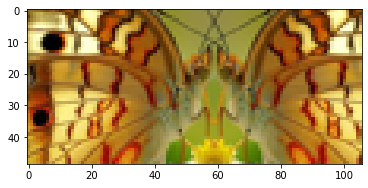

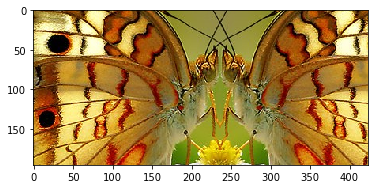

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


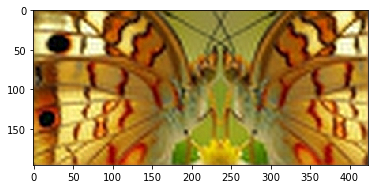

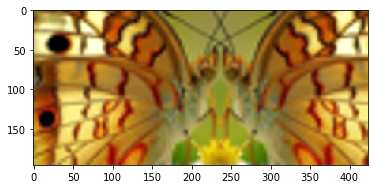

In [45]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

input, target = iter(train_loader).next()

if use_gpu:
        input = input.cuda()
        target = target.cuda()

output = net(input)

if use_gpu:
  input = input.cpu()
  output = output.cpu()
  target = target.cpu()

print(input[0].size())
bicubic = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize([int(r * input.size()[2]),
                               int(r * input.size()[3])],
                               PIL.Image.BICUBIC),
            transforms.ToTensor()
       ])
bicubic_upscaled = bicubic(input[0])

imshow(torchvision.utils.make_grid(input))
imshow(torchvision.utils.make_grid(target))
imshow(torchvision.utils.make_grid(output.detach()))
imshow(torchvision.utils.make_grid(bicubic_upscaled))

In [0]:
# Train network

In [0]:
# Evaluation with PSNR